In [40]:
from subprocess import call
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import special 
from scipy.integrate import trapezoid
import scienceplots
from brokenaxes import brokenaxes
#plt.style.use(['notebook', 'science'])

call(['gfortran', 'spin_chain.f90', '-O3', '-llapack', '-o', 'spin_chain'])
call(['gfortran', 'correl.f90', '-O3', '-lblas', '-llapack', '-o', 'correl'])

0

In [41]:
def f(x, J, origin):
    if origin == 'left':
        return 2 * x[-1] / np.pi * J * np.sin(np.pi * x[:-1]/x[-1])
    if origin == 'centre':
        return 4 * x[-1] / np.pi * J * np.cos(np.pi/2 * x[:-1]/x[-1])

def S0(a, x, J, origin):
    return 1/12*(1+1/a) * np.log(f(x, J, origin))

def S1(a, x, J, origin):
    if a < 1:
        return 0
    if np.isclose(a, 1):
        mu = -1/4
    else:
        mu = 2**(1-2/a)/(1-a) * special.gamma(.5+.5/a) / special.gamma(.5-.5/a)
    return mu * -(-1)**np.arange(len(x)-1) * f(x, J, origin)**(-1/a)

In [42]:
def s2(x, a):
    if np.isclose(x, 0.) or np.isclose(x, 1.):
        return 0.
    if np.isclose(a, 1):
        return - x * np.log(x) - (1 - x) * np.log(1 - x)
    return np.log(x**a + (1 - x)**a) / (1 - a) 

def Renyi(nu, a):
    return [np.sum([s2(pi, a) for pi in p]) for p in nu.T]

In [43]:
class SpinChain:
    def __init__(self, N, J, B):
        self.N = N
        self.J = J
        self.B = B
        self._S_cache = dict()

    def conf_length(self, x, origin):
        self.x = x
        self.origin = origin

    def diagonalise(self):
        df = pd.DataFrame([self.J, self.B])
        df.to_csv('spin_chain.dat', sep=' ', header=False, index=False)
        call(['./spin_chain', 'spin_chain.dat',  f'{self.N}'])
        self.Phi = pd.read_csv('spin_chain_data/eigenvectors.dat', sep=' ', header=None, dtype=np.float64).to_numpy()
        self.E, self.w, self.g = pd.read_csv('spin_chain_data/poly_data.dat', sep=' ', header=None, dtype=np.float64).to_numpy()
        self.P = pd.read_csv('spin_chain_data/polynomials.dat', sep=' ', header=None, dtype=np.float64).to_numpy()

    def filling(self, M):
        self.M = M
        self._S_cache = dict()
        df = pd.DataFrame(self.Phi)
        df.to_csv('spin_chain_data/eigenvectors.dat', sep=' ', header=False, index=False)
        call(['./correl',  f'{self.N}', f'{M}'])
        self.C = pd.read_csv('correl_data/correl.dat', sep=' ', header=None, dtype=np.float64).to_numpy()
        self.nu = pd.read_csv('correl_data/eigvals.dat', sep=' ', header=None, dtype=np.float64).to_numpy()
    
    def S(self, a=1):
        if a not in self._S_cache:
            self._S_cache[a] = Renyi(self.nu, a)
        return self._S_cache[a]
    
    def S_CFT(self, a=1):
        return S0(a, self.x, self.J, self.origin) + S1(a, self.x, self.J, self.origin)
        


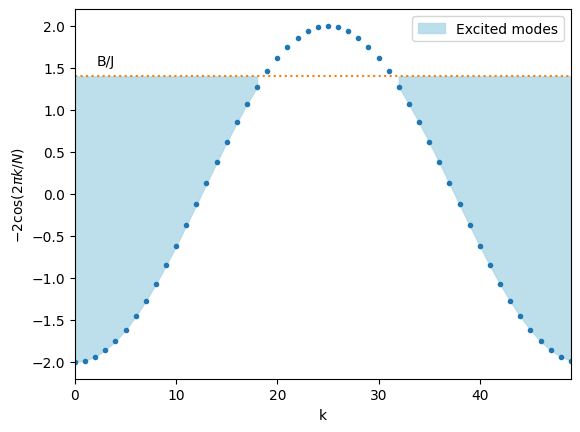

In [44]:
N = 50
J = 1
B = 1.4

kc = int(np.floor(N * np.arccos(- B / (2*J)) / (2*np.pi)))
k = np.arange(0, N)
osc = - 2*np.cos(2*np.pi*k/N)
plt.plot(k, osc, '.')
plt.plot([0, N], [B/J, B/J], ':')
plt.fill_between(k[:kc+1], osc[:kc+1], B/J, color='lightblue', alpha=.8, label='Excited modes')
plt.fill_between(k[N-kc:], osc[N-kc:], B/J, color='lightblue', alpha=.8)
plt.text(3, B/J + 0.1, 'B/J', ha='center', va='bottom') 
plt.xlabel('k')
plt.ylabel(r'$- 2\cos(2\pi k/N)$')
plt.xlim(0, N-1)
plt.ylim(-2.2, 2.2)
plt.legend()
plt.savefig('figures/homogeneous.png', bbox_inches='tight', dpi=200)

In [64]:
N = 400
EXCL = N//10
M = N//2

a = 1 / (N-1)
n = np.arange(0, N-1)
u = np.arange(1,N+1)/N
v = np.arange(-N//2+1, N//2+1)/N
#print(v)

B = np.zeros(N)

J = np.ones(N-1)
x = N * u/2
homogeneous = SpinChain(N, J, B)
homogeneous.conf_length(x, 'left')

h = 1; J = np.exp(- h * np.abs(n/N - .5))
x = N/2 * np.sign(v) * (np.exp(h*np.abs(v)) - 1) / h 
rainbow = SpinChain(N, J, B)
rainbow.conf_length(x, 'centre')

J = np.sqrt((1+n)/N * (1 - (1+n)/N))
x = N * np.arcsin(np.sqrt(u))
krawtchouk = SpinChain(N, J, B)
krawtchouk.conf_length(x, 'left')

J = np.sqrt(((1+n)/N * (1 - (1+n)/N) * (1 - (1.5 + n)/N) * (.5 + n)/N))
e = 1/(N - 1); k = 1 - 1/N; d = 2*(1-e) / (N+1)
v[-1] = .5 - e/2
x = N * special.ellipkinc(np.arcsin(2*v), k**2)
lame = SpinChain(N, J, B)
lame.conf_length(x, 'centre')

chains = [homogeneous, rainbow, krawtchouk, lame]
names = ['homogeneous', 'rainbow', 'krawtchouk', 'lame']

In [65]:
for chain in chains:
    chain.diagonalise()
    chain.filling(M)

Diagonalising L = 400 / 400

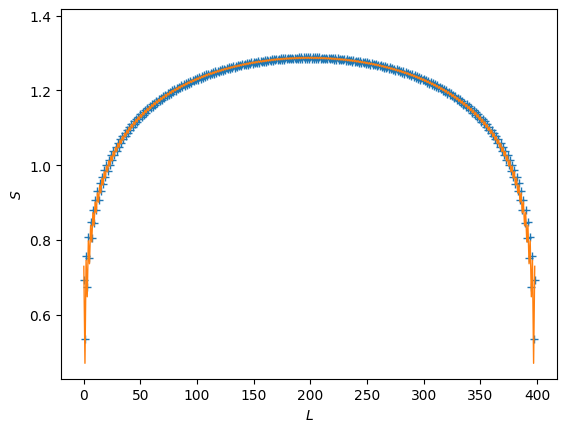

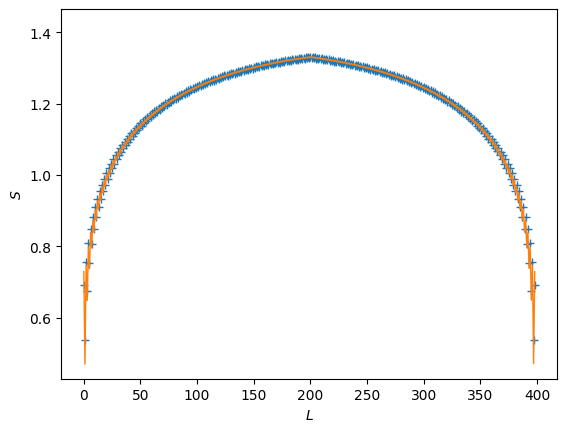

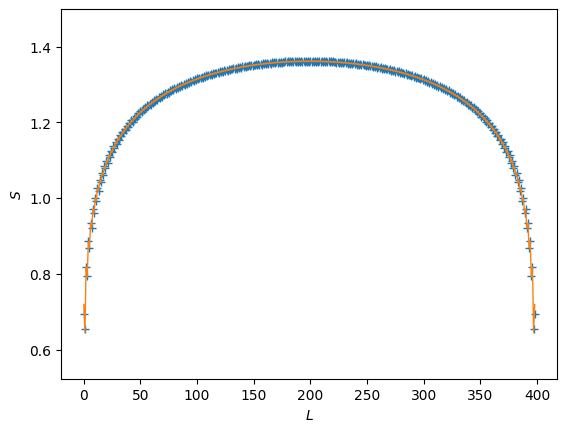

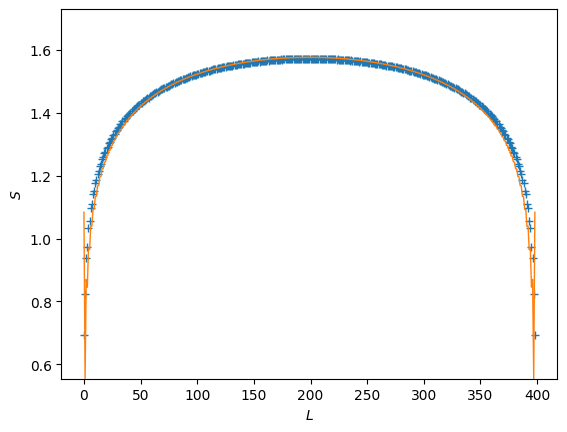

In [66]:
for chain, name in zip(chains, names):
    cp = np.mean((chain.S()[:-1] - S0(1, chain.x, chain.J, chain.origin))[EXCL:-EXCL])
    S = chain.S_CFT(1) + cp 

    plt.figure()
    plt.plot(chain.S(1)[:-1], '+')
    plt.plot(S, lw = 1)
    plt.xlabel('$L$')
    plt.ylabel('$S$')
    plt.ylim(.8 * np.min(chain.S()[:-1]), 1.1 * np.max(chain.S()[:-1]))
    plt.savefig(f'figures/{name}_1.png', bbox_inches='tight', dpi=200)

homogeneous 0.25 	 RMSE/MEAN = 1.1505
homogeneous 0.5 	 RMSE/MEAN = 0.3978
homogeneous 1 	 RMSE/MEAN = 0.5213
homogeneous 2 	 RMSE/MEAN = 0.7457
rainbow 0.25 	 RMSE/MEAN = 1.3466
rainbow 0.5 	 RMSE/MEAN = 0.4159
rainbow 1 	 RMSE/MEAN = 0.5168
rainbow 2 	 RMSE/MEAN = 0.7384
krawtchouk 0.25 	 RMSE/MEAN = 1.4644
krawtchouk 0.5 	 RMSE/MEAN = 0.5213
krawtchouk 1 	 RMSE/MEAN = 0.1518
krawtchouk 2 	 RMSE/MEAN = 0.1822
lame 0.25 	 RMSE/MEAN = 1.3489
lame 0.5 	 RMSE/MEAN = 1.3410
lame 1 	 RMSE/MEAN = 2.6487
lame 2 	 RMSE/MEAN = 2.7233


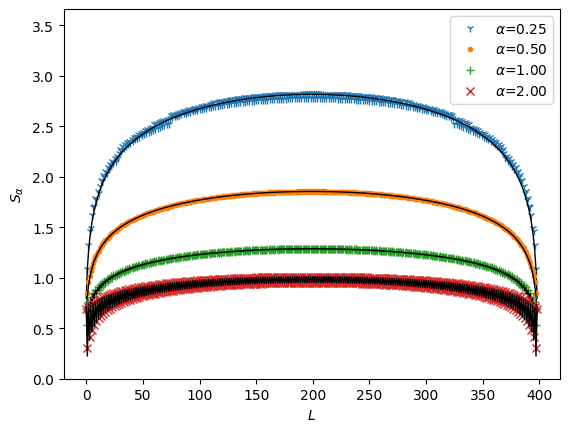

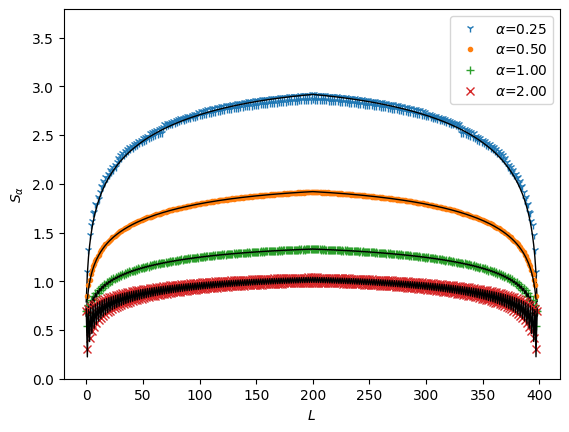

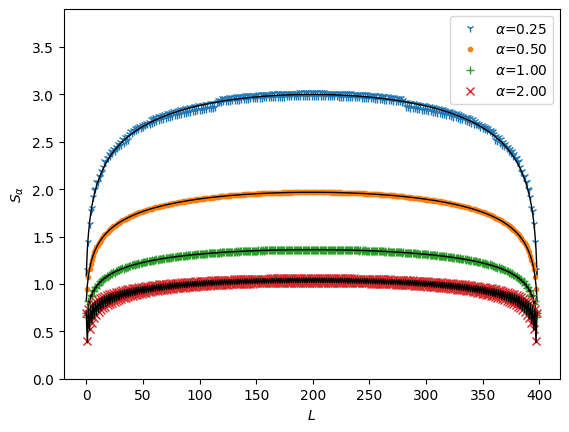

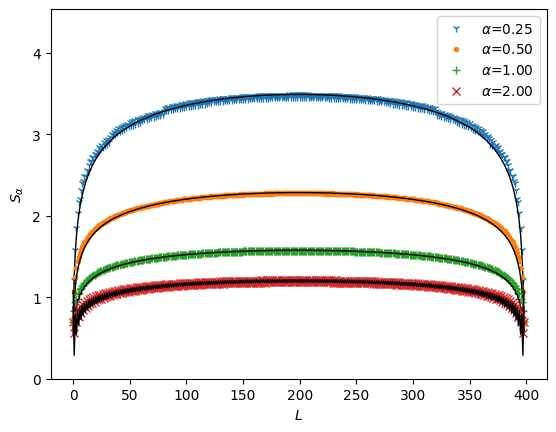

In [67]:
for chain, name in zip(chains, names):
    plt.figure()

    for ai, m in zip([.25, .5, 1, 2], ['1', '.', '+', 'x']):
        cp = np.mean((chain.S(ai)[:-1] - S0(ai, chain.x, chain.J, chain.origin))[EXCL:-EXCL])
        S = chain.S_CFT(ai) + cp 
        if ai == .25:
            plt.ylim(0, 1.3*np.max(S))
        RMSE = np.sqrt(1/(N-2)*np.sum((chain.S(ai)[:-1] - S)**2))
        MEAN = np.mean(chain.S(ai)[:-1])
        plt.plot(chain.S(ai)[:-1], m, label=rf'$\alpha$={ai:.2f}')
        plt.plot(S, 'k', lw = 1)
        print(name, ai, f'\t RMSE/MEAN = {RMSE/MEAN*100:.4f}')
    plt.xlabel('$L$')
    plt.ylabel(r'$S_\alpha$')
    plt.legend()
    plt.savefig(f'figures/{name}_a.png', bbox_inches='tight', dpi=200)

homogeneous 2 	 RMSE/MEAN = 0.7457
rainbow 2 	 RMSE/MEAN = 0.7384
krawtchouk 2 	 RMSE/MEAN = 0.1822
lame 2 	 RMSE/MEAN = 2.7233


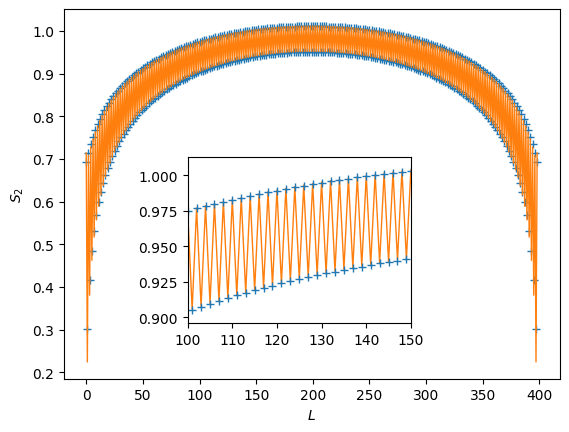

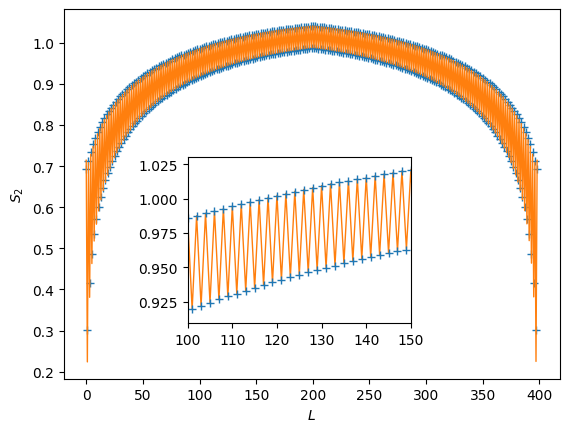

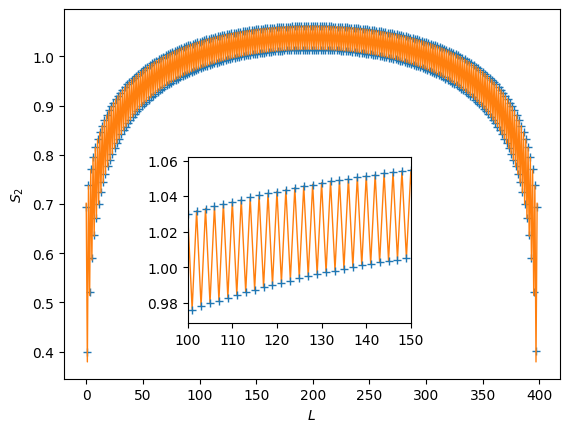

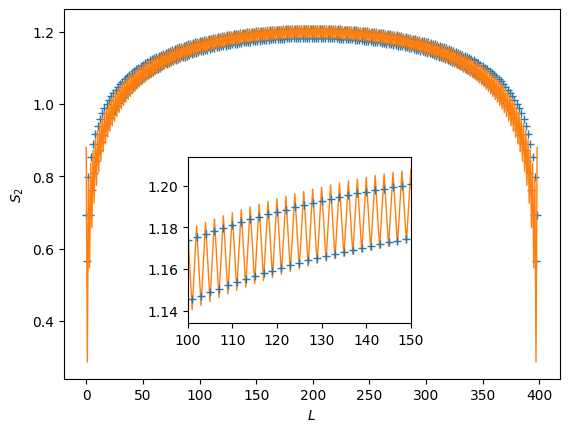

In [63]:
for chain, name in zip(chains, names):
    plt.figure()

    cp = np.mean((chain.S(2)[:-1] - S0(2, chain.x, chain.J, chain.origin))[EXCL:-EXCL])
    S = chain.S_CFT(2) + cp 
    RMSE = np.sqrt(1/(N-2)*np.sum((chain.S(2)[:-1] - S)**2))
    MEAN = np.mean(chain.S(2)[:-1])
    plt.plot(chain.S(2)[:-1], '+')
    plt.plot(S, lw = 1)
    plt.xlabel('$L$')
    plt.ylabel(r'$S_2$')

    # Create inset axes
    start = 100; stop = 150
    ax = plt.gca()
    axins = ax.inset_axes([0.25, 0.15, 0.45, 0.45])
    axins.plot(chain.S(2), '+')
    axins.plot(S, lw=1, zorder=-10)
    axins.set_xlim(start, stop)
    y_min = min(S[100:150])
    y_max = max(S[100:150])
    padding = 0.1 * (y_max - y_min)
    axins.set_ylim(y_min - padding, y_max + padding)

    print(name, 2, f'\t RMSE/MEAN = {RMSE/MEAN*100:.4f}')
    plt.savefig(f'figures/{name}_2.png', bbox_inches='tight', dpi=200)


 rainbow 0 	 RMSE/MEAN = 0.5188
Diagonalising L = 400 / 400
 rainbow 2 	 RMSE/MEAN = 0.5096
Diagonalising L = 400 / 400
 rainbow 5 	 RMSE/MEAN = 0.5004
Diagonalising L = 400 / 400
 rainbow 10 	 RMSE/MEAN = 0.4819
Diagonalising L = 400 / 400
 rainbow 200 	 RMSE/MEAN = 0.4819


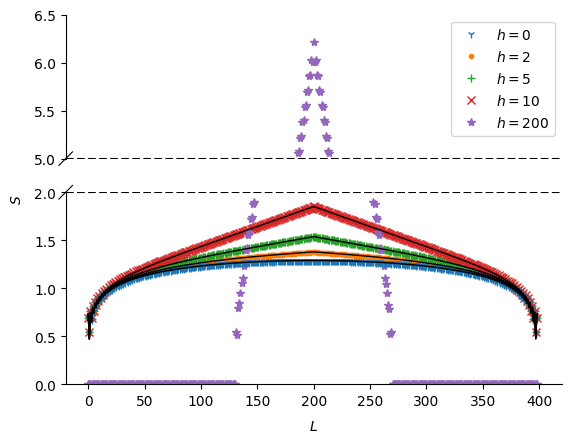

In [50]:
plt.figure()
c1 = 2
c2 = 5
bax = brokenaxes(xlims=((-20, 420),), ylims=((0, c1), (c2, 6.5)), wspace=.05)
bax.set_xlabel('$L$', labelpad=25)
bax.set_ylabel('$S$')
for h, m in zip([0, 2, 5, 10, 200], ['1', '.', '+', 'x', '*']):
    if h == 0:
        cp = np.mean(homogeneous.S()[:-1] - S0(1, homogeneous.x, homogeneous.J, homogeneous.origin))
        S = homogeneous.S_CFT() + cp 
        RMSE = np.sqrt(1/(N-2)*np.sum((homogeneous.S(1)[:-1] - S)**2))
        MEAN = np.mean(homogeneous.S()[:-1])
        bax.plot(homogeneous.S()[:-1], m, label=f'$h={h}$')
        bax.plot(S, 'k', lw = 1)
        print('\n rainbow', h, f'\t RMSE/MEAN = {RMSE/MEAN*100:.4f}')
    else:
        J = np.exp(- h * np.abs(n/N - .5))
        v = np.arange(-N//2+1, N//2+1)/N
        x = N/2 * np.sign(v) * (np.exp(h*np.abs(v)) - 1) / h 
        rainbow = SpinChain(N, J, B)
        rainbow.conf_length(x, 'centre')
        rainbow.diagonalise()
        rainbow.filling(M)
        bax.plot(rainbow.S()[:-1], m, label=f'$h={h}$', zorder=-1)

        if h != 200:
            cp = np.mean(rainbow.S()[:-1] - S0(1, rainbow.x, rainbow.J, rainbow.origin))
            S = rainbow.S_CFT() + cp 
            RMSE = np.sqrt(1/(N-2)*np.sum((rainbow.S()[:-1] - S)**2))
            MEAN = np.mean(rainbow.S()[:-1])
            bax.plot(S, 'k', lw = 1, zorder=100)
        
        print('\n rainbow', h, f'\t RMSE/MEAN = {RMSE/MEAN*100:.4f}')
bax.plot([-20, 420], [c1, c1], 'k--')
bax.plot([-20, 420], [c2, c2], 'k--')
bax.legend()
plt.savefig(f'figures/rainbow_h.png', bbox_inches='tight', dpi=200)

Diagonalising L = 400 / 400
 25
Diagonalising L = 400 / 400
 50
Diagonalising L = 400 / 400
 100
Diagonalising L = 400 / 400
 200
Diagonalising L = 400 / 400
 25
Diagonalising L = 400 / 400
 50
Diagonalising L = 400 / 400
 100
Diagonalising L = 400 / 400
 200
Diagonalising L = 400 / 400
 25
Diagonalising L = 400 / 400
 50
Diagonalising L = 400 / 400
 100
Diagonalising L = 400 / 400
 200
Diagonalising L = 400 / 400
 25
Diagonalising L = 400 / 400
 50
Diagonalising L = 400 / 400
 100
Diagonalising L = 400 / 400
 200


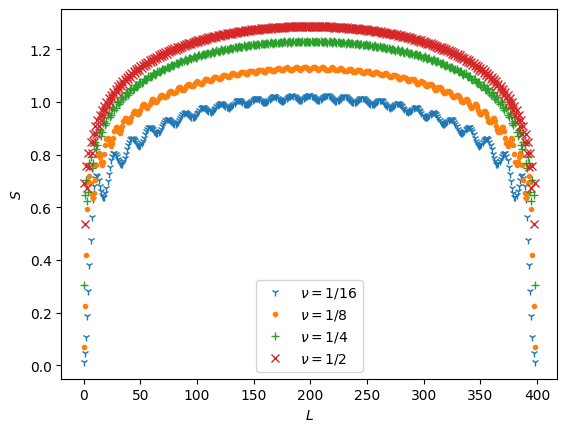

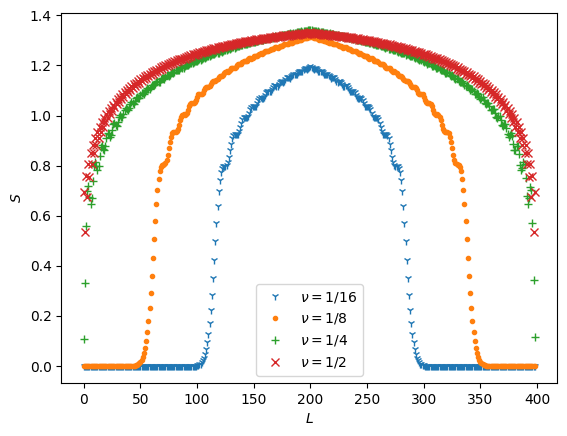

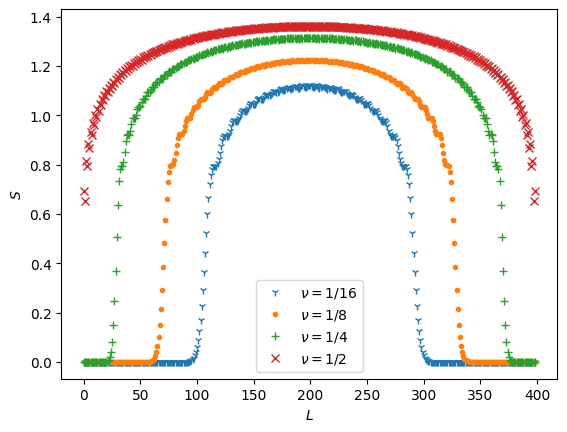

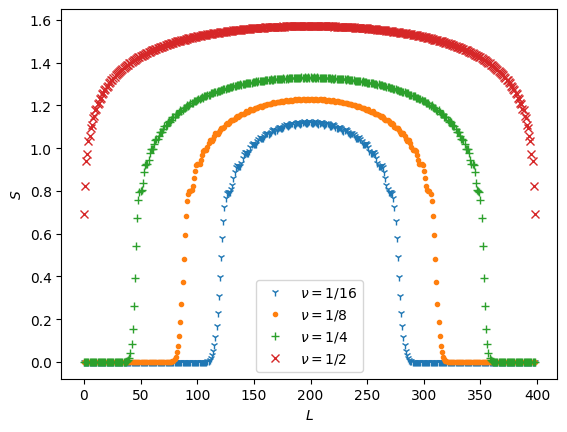

In [51]:
h = 1; J = np.exp(- h * np.abs(n/N - .5))
x = N/2 * np.sign(v) * (np.exp(h*np.abs(v)) - 1) / h 
rainbow = SpinChain(N, J, B)
rainbow.conf_length(x, 'centre')

chains = [homogeneous, rainbow, krawtchouk, lame]

for chain, name in zip(chains, names):
    plt.figure()

    for M, m in zip([16, 8, 4, 2], ['1', '.', '+', 'x']):
        chain.diagonalise()
        chain.filling(N//M)
        print('\n', chain.M)

        plt.plot(chain.S()[:-1], m, label=fr'$\nu=1/{M}$')
        plt.xlabel('$L$')
        plt.ylabel('$S$')
    plt.legend()
    plt.savefig(f'figures/{name}_filling.png', bbox_inches='tight', dpi=200)

In [52]:
chain = krawtchouk
chain.filling(N//8)

Diagonalising L = 400 / 400

/tmp/ipykernel_24266/1762754129.py:5: RuntimeWarning: divide by zero encountered in divide
  A = np.nan_to_num(1 / np.sqrt(chain.J*K), posinf=0)


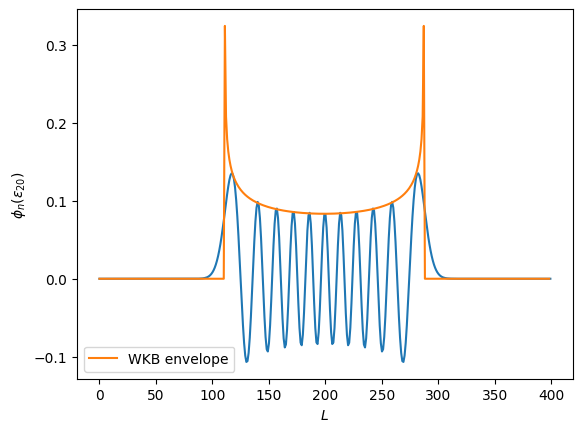

In [53]:
plt.figure()
k = 20
K = np.real(np.sqrt(2 + chain.E[k] / chain.J +0j))
K[np.abs(K) < 1e-5] = 0
A = np.nan_to_num(1 / np.sqrt(chain.J*K), posinf=0)
Phi = np.sqrt(2)*A / np.sqrt(np.sum(A**2))
plt.plot(chain.Phi[:, k])
plt.plot(Phi, label='WKB envelope')
plt.xlabel('$L$')
plt.ylabel(fr'$\phi_{{n}}(\varepsilon_{{{k}}})$')
plt.legend()
plt.savefig('figures/eigenvector.png', bbox_inches='tight', dpi=200)

Diagonalising L = 400 / 400
 25
homogeneous 1/16 	 RMSE = 0.0077,  MEAN = 0.0627,  RMSE/MEAN = 12.2993
Diagonalising L = 400 / 400
 50
homogeneous 1/8 	 RMSE = 0.0094,  MEAN = 0.1253,  RMSE/MEAN = 7.4739
Diagonalising L = 400 / 400
 100
homogeneous 1/4 	 RMSE = 0.0121,  MEAN = 0.2504,  RMSE/MEAN = 4.8501
Diagonalising L = 400 / 400
 200
homogeneous 1/2 	 RMSE = 0.0508,  MEAN = 0.5000,  RMSE/MEAN = 10.1576
Diagonalising L = 400 / 400
 25
rainbow 1/16 	 RMSE = 0.0048,  MEAN = 0.0627,  RMSE/MEAN = 7.6644


/tmp/ipykernel_24266/927399502.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400
 50
rainbow 1/8 	 RMSE = 0.0051,  MEAN = 0.1253,  RMSE/MEAN = 4.0664


/tmp/ipykernel_24266/927399502.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400
 100
rainbow 1/4 	 RMSE = 0.0127,  MEAN = 0.2506,  RMSE/MEAN = 5.0761
Diagonalising L = 400 / 400
 200
rainbow 1/2 	 RMSE = 0.0508,  MEAN = 0.5000,  RMSE/MEAN = 10.1576
Diagonalising L = 400 / 400
 25
krawtchouk 1/16 	 RMSE = 0.0044,  MEAN = 0.0627,  RMSE/MEAN = 7.0832


/tmp/ipykernel_24266/927399502.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400
 50
krawtchouk 1/8 	 RMSE = 0.0058,  MEAN = 0.1253,  RMSE/MEAN = 4.6161


/tmp/ipykernel_24266/927399502.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400
 100
krawtchouk 1/4 	 RMSE = 0.0131,  MEAN = 0.2506,  RMSE/MEAN = 5.2258


/tmp/ipykernel_24266/927399502.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400
 200
krawtchouk 1/2 	 RMSE = 0.0508,  MEAN = 0.5000,  RMSE/MEAN = 10.1510
Diagonalising L = 400 / 400
 25
lame 1/16 	 RMSE = 0.0056,  MEAN = 0.0627,  RMSE/MEAN = 8.8918


/tmp/ipykernel_24266/927399502.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400
 50
lame 1/8 	 RMSE = 0.0078,  MEAN = 0.1253,  RMSE/MEAN = 6.2478


/tmp/ipykernel_24266/927399502.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400
 100
lame 1/4 	 RMSE = 0.0175,  MEAN = 0.2506,  RMSE/MEAN = 6.9827


/tmp/ipykernel_24266/927399502.py:9: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)


Diagonalising L = 400 / 400
 200
lame 1/2 	 RMSE = 0.0505,  MEAN = 0.5000,  RMSE/MEAN = 10.1066


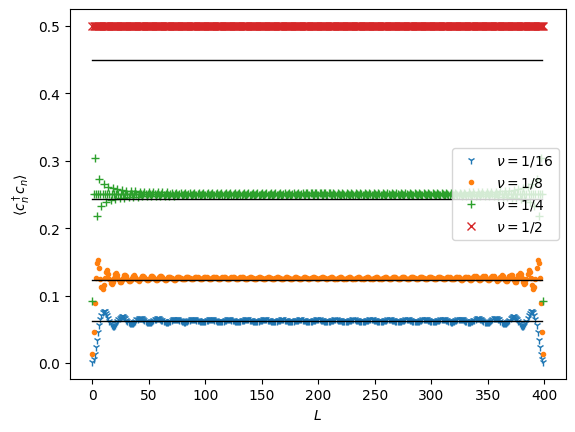

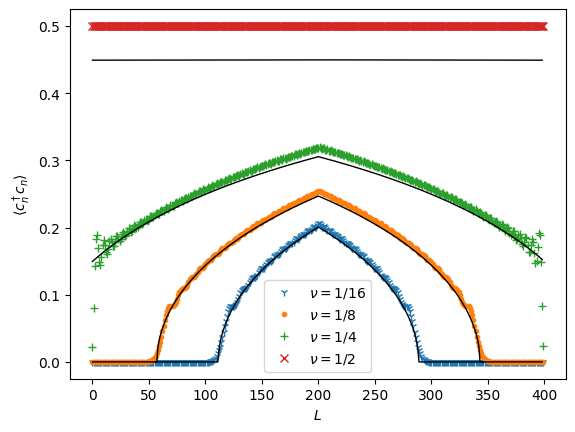

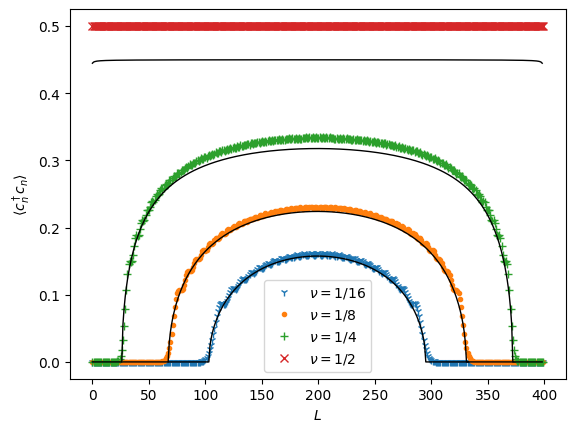

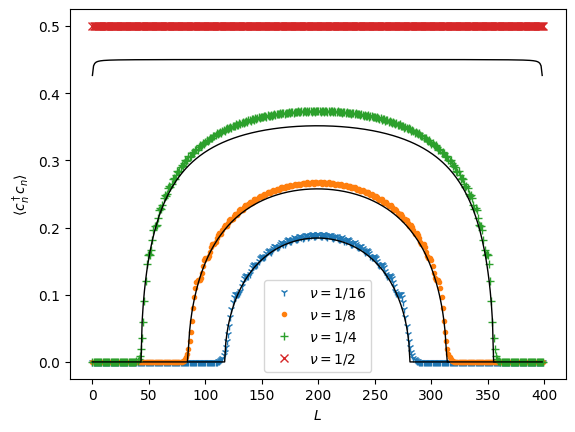

In [54]:
for chain, name in zip(chains, names):
    plt.figure()

    for M, m in zip([16, 8, 4, 2], ['1', '.', '+', 'x']):
        chain.diagonalise()
        chain.filling(N//M)
        print('\n', chain.M)

        r = 1/np.pi * np.sqrt(2 + (chain.E[N//M - 1] + B[:-1]) / chain.J)
        r = np.nan_to_num(r)

        plt.plot(np.diag(chain.C), m, label=fr'$\nu=1/{M}$')
        plt.plot(r, 'k', lw=1)
        plt.xlabel('$L$')
        plt.ylabel(r'$\langle c^\dagger_n c_n\rangle$')

        RMSE = np.sqrt(1/(len(r[r > 0]) - 1) * np.sum(((np.diag(chain.C)[:-1])[r > 0] - r[r > 0])**2))
        MEAN = np.mean(np.diag(chain.C)[:-1])
        print(name, f'1/{M}', f'\t RMSE = {RMSE:.4f}, ', f'MEAN = {MEAN:.4f}, ', f'RMSE/MEAN = {RMSE/MEAN*100:.4f}')
        
    plt.legend()
    plt.savefig(f'figures/{name}_occupation.png', bbox_inches='tight', dpi=200)

In [55]:
N = 400
M = N//8

a = 1 / (N-1)
n = np.arange(0, N-1)
u = np.arange(1,N+1)/N
v = np.arange(-N//2+1, N//2+1)/N

J = np.sqrt((1+n)/N * (1 - (1+n)/N))
x = N * np.arcsin(np.sqrt(u))
krawtchouk = SpinChain(N, J, B)
krawtchouk.conf_length(x, 'left')

J = np.sqrt(((1+n)/N * (1 - (1+n)/N) * (1 - (1.5 + n)/N) * (.5 + n)/N))
e = 1/(N - 1); k = 1 - 1/N; d = 2*(1-e) / (N+1)
v[0] = - 1 + e + 1/N
v[-1] = 1 - e
x = k*N * special.ellipkinc(np.arcsin(v), k**2)
lame = SpinChain(N, J, B)
lame.conf_length(x, 'centre')

Diagonalising L = 400 / 400

/tmp/ipykernel_24266/3172362020.py:12: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (krawtchouk.E[M - 1]+B[:-1]) / J)



 krawtchouk 0.1 50 	 RMSE = 0.0297,  MEAN = 0.1230,  RMSE/MEAN = 24.1790
Diagonalising L = 400 / 400

/tmp/ipykernel_24266/3172362020.py:12: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (krawtchouk.E[M - 1]+B[:-1]) / J)



 krawtchouk 0.5 50 	 RMSE = 0.0058,  MEAN = 0.1253,  RMSE/MEAN = 4.6161
Diagonalising L = 400 / 400

/tmp/ipykernel_24266/3172362020.py:12: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (krawtchouk.E[M - 1]+B[:-1]) / J)



 krawtchouk 0.9 50 	 RMSE = 0.0415,  MEAN = 0.1253,  RMSE/MEAN = 33.1018


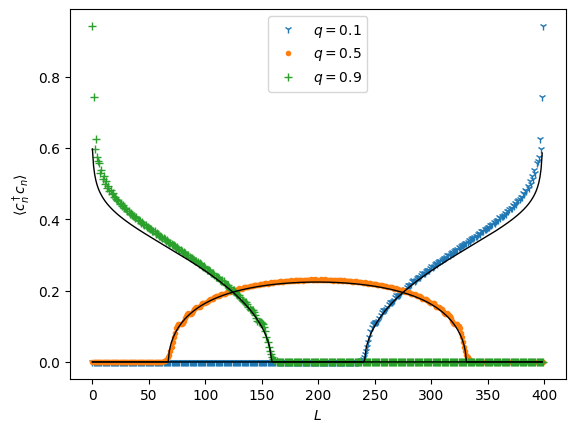

In [56]:
plt.figure()
for q, m in zip([.1, .5, .9], ['1', '.', '+', 'x']):
    n = np.arange(0, N-1)
    J = np.sqrt(q*(1-q) * (1+n)/N * (1 - (1+n)/N))
    n = np.arange(0, N)
    B = q * (1 - 1/N) + (1 - 2*q) * n/N
    krawtchouk.J = J
    krawtchouk.B = B
    krawtchouk.diagonalise()
    krawtchouk.filling(M)

    r = 1/np.pi * np.sqrt(2 + (krawtchouk.E[M - 1]+B[:-1]) / J)
    r = np.nan_to_num(r)

    plt.plot(np.diag(krawtchouk.C), m, label=fr'$q={q}$')
    plt.plot(r, 'k', lw=1, zorder=10)
    plt.xlabel('$L$')
    plt.ylabel(r'$\langle c^\dagger_n c_n\rangle$')

    RMSE = np.sqrt(1/(len(r[r > 0]) - 1) * np.sum(((np.diag(krawtchouk.C)[:-1])[r > 0] - r[r > 0])**2))
    MEAN = np.mean(np.diag(krawtchouk.C)[:-1])
    print('\n krawtchouk', f'{q}', f'{M}', f'\t RMSE = {RMSE:.4f}, ', f'MEAN = {MEAN:.4f}, ', f'RMSE/MEAN = {RMSE/MEAN*100:.4f}')

plt.legend()
plt.savefig(f'figures/krawtchouk_B.png', bbox_inches='tight', dpi=200)

Diagonalising L = 400 / 400

/tmp/ipykernel_24266/3633247463.py:12: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (lame.E[M - 1]+B[:-1]) / J)



 lamé 0.1 50 	 RMSE = 0.0110,  MEAN = 0.1253,  RMSE/MEAN = 8.7977
Diagonalising L = 400 / 400
 lamé 0.5 50 	 RMSE = 0.0078,  MEAN = 0.1253,  RMSE/MEAN = 6.2478


/tmp/ipykernel_24266/3633247463.py:12: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (lame.E[M - 1]+B[:-1]) / J)


Diagonalising L = 400 / 400

/tmp/ipykernel_24266/3633247463.py:12: RuntimeWarning: invalid value encountered in sqrt
  r = 1/np.pi * np.sqrt(2 + (lame.E[M - 1]+B[:-1]) / J)



 lamé 0.9 50 	 RMSE = 0.0070,  MEAN = 0.1253,  RMSE/MEAN = 5.6119


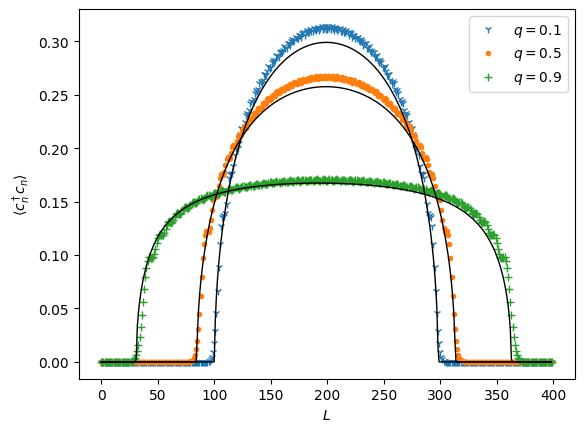

In [57]:
plt.figure()
for q, m in zip([.1, .5, .9], ['1', '.', '+', 'x']):
    n = np.arange(0, N-1)
    J = np.sqrt(((1+n)/N * (1 - (1+n)/N) * (1 - (1.5 + n)/N) * (.5 + n)/N))
    n = np.arange(0, N)
    B = -.5 * (1 - 2*q) * ((2*n + 1) / N - 1)**2
    lame.J = J
    lame.B = B
    lame.diagonalise()
    lame.filling(M)

    r = 1/np.pi * np.sqrt(2 + (lame.E[M - 1]+B[:-1]) / J)
    r = np.nan_to_num(r)

    plt.plot(np.diag(lame.C), m, label=fr'$q={q}$')
    plt.plot(r, 'k', lw=1, zorder=10)
    plt.xlabel('$L$')
    plt.ylabel(r'$\langle c^\dagger_n c_n\rangle$')

    RMSE = np.sqrt(1/(len(r[r > 0]) - 1) * np.sum(((np.diag(lame.C)[:-1])[r > 0] - r[r > 0])**2))
    MEAN = np.mean(np.diag(lame.C)[:-1])
    print('\n lamé', f'{q}', f'{M}', f'\t RMSE = {RMSE:.4f}, ', f'MEAN = {MEAN:.4f}, ', f'RMSE/MEAN = {RMSE/MEAN*100:.4f}')

plt.legend()
plt.savefig(f'figures/lame_B.png', bbox_inches='tight', dpi=200)